In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

#### The dataset comes from https://www.kaggle.com/nehaprabhavalkar/av-healthcare-analytics-ii?select=healthcare
#### Acknowledge https://datahack.analyticsvidhya.com/contest/janatahack-healthcare-analytics-ii/#ProblemStatement


##### The following notebook is divided into Three parts:

 - Exploration of the dataset
 - Preparing dataset for the Machine Learnign Model
 - Machine Learning Modelling
 
##### The aim of this notebook is to build the Machine Learning model that will be able to predict the length of stay at the hospital, however rahter then using the regression models I will use the classification models to predict the LOS. 

##### The length of stay will be divided into 3 categories depedning on the number of days, i.e 1-3 days would be 1 - threfore machone learning model will try to predict the expected period of stay for each patient rather then predicting the actual number which in my opinion we could never really detremine.

### __Data Description__

 -  case_id  Stay  Case_ID registered in Hospital 
 -                       Hospital_code  Unique code for the Hospital  
 -                   Hospital_type_code  Unique code for the type of Hospital  
 -                   City_Code_Hospital  City Code of the Hospital
 -                 Hospital_region_code  Region Code of the Hospital
 -    Available Extra Rooms in Hospital  Number of Extra rooms available in the Hospital
 -                           Department  Department overlooking the case
 -                            Ward_Type  Code for the Ward type
 -                   Ward_Facility_Code  Code for the Ward Facility
 -                            Bed Grade  Condition of Bed in the Ward
 -                           patientid   Unique Patient Id
 -                   City_Code_Patient   City Code for the patient
 -                   Type of Admission   Admission Type registered by the Hospital
 -                 Severity of Illness   Severity of the illness recorded at the time o...  
 -               Visitors with Patient   Number of Visitors with the patient
 -                                 Age   Age of the patient 
 -                   Admission_Deposit   Deposit at the Admission Time
 -                                Stay   Stay Days by the patient

                             
                        
                     

In [4]:
# Loading the datasets 
training_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

## Data Exploration

In [5]:
# Lets check for null values in either of the columns
training_df.isna().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [6]:
# Drop na values in each column
training_df.dropna(inplace=True)

In [7]:
train_dc = pd.read_csv("train_data_dictionary.csv")

In [8]:
# Lets just see the top of the train dataset 
training_df.head()


,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [9]:
# Deleting patientid and case id from the dataframe so there is no miss conclusions about the data 
training_df.drop(columns=["case_id","patientid"], inplace=True, index = 1)


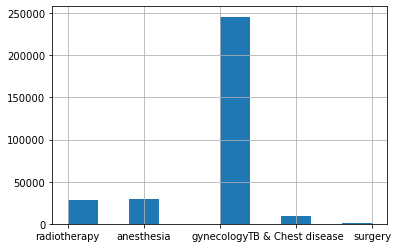

In [10]:
# Lets see the distribution for Department - how many occurances of each unique value are there
training_df['Department'].hist();

In [11]:
# It is quite noticable that most of patients are in the gyneacology
# Lets see the histogram for length of stay but only for gynacology department

gyn_df = training_df[training_df['Department']=='gynecology']

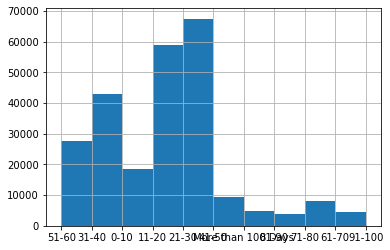

In [12]:
gyn_df['Stay'].hist();

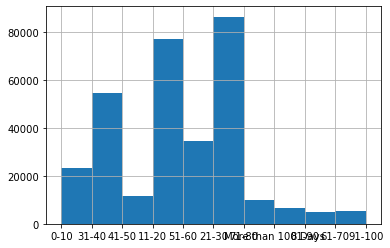

In [13]:
# The graph shows us straight away that first we got the right skewness and that most of patients has a length of stay from 40 to 60 days within gyneacolgoy department

# Lets now compare that to the whole dataset and see if there is a difference 

training_df['Stay'].hist();

###### Graphs are almost identical, that means that we will need to carry out the normalization s we dont want to see the right skewness 
###### but the normal distribution which is ideal for the model - more on that later

#### Lets see the distribution for the rest of the columns 

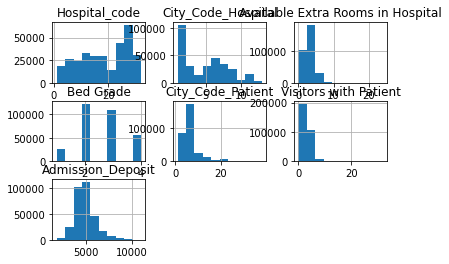

In [14]:
training_df.hist();

### Lets see how the Type of admission affects the LOS(Length of Stay), to do that I will get each admission type and then calcaulate the mean and median for each of them types

##### Becasue the Stay doesn't have a number but the range of periods of length of stay days, I will need to get distinct valeus from it, then based on that data I will be able to change those to numbers based on system 1 to nth range, which then will make it able to calcualte the mean and meadian. Those can then be transformed back into orginal and the mean range can be given.

In [15]:
# Lets get unique values from LOS (that would be all the ranges)
unique_los = training_df['Stay'].unique()
unique_los

array(['0-10', '31-40', '41-50', '11-20', '51-60', '21-30', '71-80',
       'More than 100 Days', '81-90', '61-70', '91-100'], dtype=object)

In [16]:
# Lets change the ranges to the numbers by suing loc functions becasue it is much faster than doing the for loop

training_df.loc[training_df.Stay == '0-10', 'Stay'] = 1
training_df.loc[training_df.Stay == '41-50', 'Stay'] = 2
training_df.loc[training_df.Stay == '31-40', 'Stay'] = 3
training_df.loc[training_df.Stay == '11-20', 'Stay'] = 4
training_df.loc[training_df.Stay == '51-60', 'Stay'] = 5
training_df.loc[training_df.Stay == '21-30', 'Stay'] = 6
training_df.loc[training_df.Stay == '71-80', 'Stay'] = 7
training_df.loc[training_df.Stay == 'More than 100 Days', 'Stay'] = 8
training_df.loc[training_df.Stay == '81-90', 'Stay'] = 9
training_df.loc[training_df.Stay == '61-70', 'Stay'] = 10
training_df.loc[training_df.Stay == '91-100', 'Stay'] = 11

In [17]:
departments_types = training_df['Type of Admission'].unique()
print(departments_types)

['Emergency' 'Trauma' 'Urgent']


In [18]:
## Lets create the dataframes - that will help to maintain and visaulize the calculations
trauma_department = training_df[training_df['Type of Admission']=='Trauma']
emergency_department = training_df[training_df['Type of Admission']=='Emergency']
urgent_department = training_df[training_df['Type of Admission']=='Urgent']


departments_data = {'Department Types':['Emergency','Trauma', 'Urgent'],
                    'Mean': [emergency_department['Stay'].mean(),trauma_department['Stay'].mean(),urgent_department['Stay'].mean()],
                    'Median': [emergency_department['Stay'].median(),trauma_department['Stay'].median(),urgent_department['Stay'].median()],
                    'Variance': [emergency_department['Stay'].var(),trauma_department['Stay'].var(),urgent_department['Stay'].var()]
                     }
department_df_calc = pd.DataFrame(departments_data)

In [19]:
department_df_calc

,Department Types,Mean,Median,Variance
0,Emergency,4.321709,4.0,3.966975
1,Trauma,4.772634,5.0,3.341343
2,Urgent,4.461680,4.0,3.372891


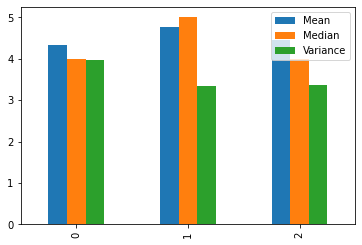

In [20]:

department_df_calc.plot.bar();

#### It is noticable by median that the patients with trauma are expected to have more days of stay (51-60 da\ys) and with the lowest variance meaning that most of the data points should fall around the mean of 5 (we round it to 0 decimal places), however slightly bigger variance is for patients from Emergency

In [21]:
## Lets see how LOS varies based on the hospital 

# First lets get unique values for hospital type code 
training_df['Hospital_type_code'].unique()

array(['c', 'e', 'b', 'a', 'f', 'd', 'g'], dtype=object)

In [22]:
# Lets see the avarage length of stay for each hospital type code
hosp_code_a = training_df[training_df['Hospital_type_code']=='a']
hosp_code_b = training_df[training_df['Hospital_type_code']=='b']
hosp_code_c = training_df[training_df['Hospital_type_code']=='c']
hosp_code_d = training_df[training_df['Hospital_type_code']=='d']
hosp_code_e = training_df[training_df['Hospital_type_code']=='e']
hosp_code_f = training_df[training_df['Hospital_type_code']=='f']
hosp_code_g = training_df[training_df['Hospital_type_code']=='g']
departments_data = {'Department Types':['a','b', 'c','d','e','f','g'],
                    'Mean': [hosp_code_a['Stay'].mean(),hosp_code_b['Stay'].mean(),hosp_code_c['Stay'].mean(),hosp_code_d['Stay'].mean(), hosp_code_e['Stay'].mean(),hosp_code_f['Stay'].mean(),hosp_code_g['Stay'].mean()],
                    'Median': [hosp_code_a['Stay'].median(),hosp_code_b['Stay'].median(),hosp_code_c['Stay'].median(),hosp_code_d['Stay'].median(), hosp_code_e['Stay'].median(),hosp_code_f['Stay'].median(),hosp_code_g['Stay'].median()],
                    'Variance': [hosp_code_a['Stay'].var(),hosp_code_b['Stay'].var(),hosp_code_c['Stay'].var(),hosp_code_d['Stay'].var(), hosp_code_e['Stay'].var(),hosp_code_f['Stay'].var(),hosp_code_g['Stay'].var()]
                     }

In [23]:
department_code_df = pd.DataFrame(departments_data)

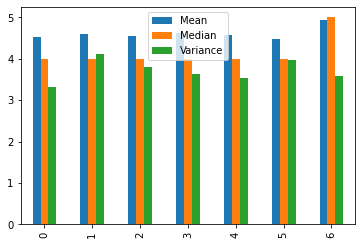

In [24]:
department_code_df.plot.bar();

In [25]:
# To see the correlation between all the columns first we need to change the categorized data inot quantitive data using label encoding

# First lets change the values in the Department to numeric
training_df['Department'] = training_df["Department"].astype('category')
training_df['Department'] = training_df['Department'].cat.codes
training_df.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,c,3,Z,3,3,R,F,2.0,7.0,Emergency,Extreme,2,51-60,4911.0,1
2,10,e,1,X,2,1,S,E,2.0,7.0,Trauma,Extreme,2,51-60,4745.0,3
3,26,b,2,Y,2,3,R,D,2.0,7.0,Trauma,Extreme,2,51-60,7272.0,2
4,26,b,2,Y,2,3,S,D,2.0,7.0,Trauma,Extreme,2,51-60,5558.0,2
5,23,a,6,X,2,1,S,F,2.0,7.0,Trauma,Extreme,2,51-60,4449.0,4


In [26]:
# lets change the values in the Ward_type column to numeric
training_df['Ward_Type'] = training_df["Ward_Type"].astype('category')
training_df['Ward_Type'] = training_df['Ward_Type'].cat.codes
training_df.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,c,3,Z,3,3,2,F,2.0,7.0,Emergency,Extreme,2,51-60,4911.0,1
2,10,e,1,X,2,1,3,E,2.0,7.0,Trauma,Extreme,2,51-60,4745.0,3
3,26,b,2,Y,2,3,2,D,2.0,7.0,Trauma,Extreme,2,51-60,7272.0,2
4,26,b,2,Y,2,3,3,D,2.0,7.0,Trauma,Extreme,2,51-60,5558.0,2
5,23,a,6,X,2,1,3,F,2.0,7.0,Trauma,Extreme,2,51-60,4449.0,4


In [27]:
# lets change the values in the rest of the columns where values are categorical to numeric
training_df['Ward_Facility_Code'] = training_df["Ward_Facility_Code"].astype('category')
training_df['Ward_Facility_Code'] = training_df['Ward_Facility_Code'].cat.codes


training_df['Type of Admission'] = training_df["Type of Admission"].astype('category')
training_df['Type of Admission'] = training_df['Type of Admission'].cat.codes

# lets change the values in the Ward_type column to numeric
training_df['Severity of Illness'] = training_df["Severity of Illness"].astype('category')
training_df['Severity of Illness'] = training_df['Severity of Illness'].cat.codes

training_df.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,c,3,Z,3,3,2,5,2.0,7.0,0,0,2,51-60,4911.0,1
2,10,e,1,X,2,1,3,4,2.0,7.0,1,0,2,51-60,4745.0,3
3,26,b,2,Y,2,3,2,3,2.0,7.0,1,0,2,51-60,7272.0,2
4,26,b,2,Y,2,3,3,3,2.0,7.0,1,0,2,51-60,5558.0,2
5,23,a,6,X,2,1,3,5,2.0,7.0,1,0,2,51-60,4449.0,4


In [28]:
# Lets make sure that all the valeus are now numeric

training_df.dtypes

Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                              int8
Ward_Type                               int8
Ward_Facility_Code                      int8
Bed Grade                            float64
City_Code_Patient                    float64
Type of Admission                       int8
Severity of Illness                     int8
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object

In [29]:
# lets chane the object columns to numeric
# lets change the values in the Hosputal Type_code column to numeric
training_df['Hospital_type_code'] = training_df["Hospital_type_code"].astype('category')
training_df['Hospital_type_code'] = training_df['Hospital_type_code'].cat.codes



In [30]:
# Lets check the age columns unique values since it is the range of the age, it needs to be converted the same way as the Stay column was converted

training_df['Age'].unique()

array(['51-60', '71-80', '31-40', '41-50', '81-90', '61-70', '21-30',
       '11-20', '0-10', '91-100'], dtype=object)

In [31]:
# Lets now convert it to the appropaite number
training_df.loc[training_df.Age == '0-10', 'Age'] = 1
training_df.loc[training_df.Age == '11-20', 'Age'] = 2
training_df.loc[training_df.Age == '21-30', 'Age'] = 3
training_df.loc[training_df.Age == '31-40', 'Age'] = 4
training_df.loc[training_df.Age == '41-50', 'Age'] = 5
training_df.loc[training_df.Age == '51-60', 'Age'] = 6
training_df.loc[training_df.Age == '61-70', 'Age'] = 7
training_df.loc[training_df.Age == '71-80', 'Age'] = 8
training_df.loc[training_df.Age == '81-90', 'Age'] = 9
training_df.loc[training_df.Age == '91-100', 'Age'] = 10

In [32]:
# Lets makes sure that all columns got converted
training_df.dtypes

Hospital_code                          int64
Hospital_type_code                      int8
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                              int8
Ward_Type                               int8
Ward_Facility_Code                      int8
Bed Grade                            float64
City_Code_Patient                    float64
Type of Admission                       int8
Severity of Illness                     int8
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object

In [33]:
# As age and stay columns still is object but they were changed to numeric, so now they can be converted to int types 
training_df['Age'] = training_df['Age'].astype('string').astype('int')
training_df['Stay'] = training_df['Stay'].astype('string').astype('int')


In [34]:
training_df.dtypes

Hospital_code                          int64
Hospital_type_code                      int8
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                              int8
Ward_Type                               int8
Ward_Facility_Code                      int8
Bed Grade                            float64
City_Code_Patient                    float64
Type of Admission                       int8
Severity of Illness                     int8
Visitors with Patient                  int64
Age                                    int32
Admission_Deposit                    float64
Stay                                   int32
dtype: object

### Now the dataframe is ready to do futher calculations including the correlation matrix but also it is read to be an input for the machine learning model

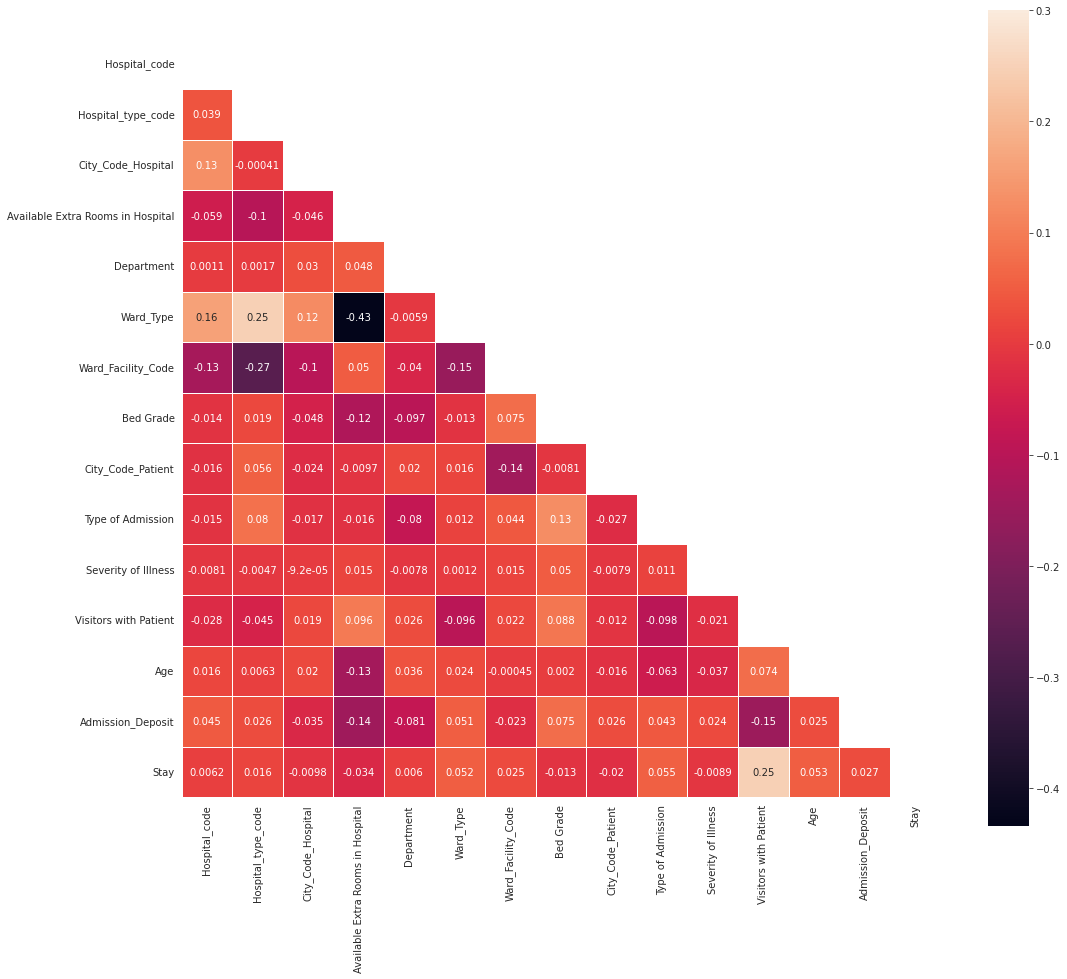

In [35]:
# Lets see on the correalation mattrix for all the columns
import seaborn as sns
corr = training_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(17, 15))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,linewidths=.5,annot=True)

In [36]:
training_df['Hospital_region_code'] = training_df["Hospital_region_code"].astype('category')
training_df['Hospital_region_code'] = training_df['Hospital_region_code'].cat.codes
training_df.head()
# creating the copy of training_df for future possible use
training_df_copy = training_df

In [37]:
# Lets split the data into training set
x = training_df.drop(columns=["Stay"])
Y = training_df["Stay"]
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.20, random_state = 42)


# First initialize all the models thatare going to be used inside the function
def fit_score_models(x,Y,x_test,Y_test):
    random_forest_clf = RandomForestClassifier().fit(x,Y)
    ada_clf = AdaBoostClassifier().fit(x,Y)
    tree_clf = DecisionTreeClassifier().fit(x,Y)
    knearest_clf = KNeighborsClassifier().fit(x,Y)
    
    rnd_forest_pred = random_forest_clf.predict(x_test)
    rnd_forest_pred_acc = metrics.accuracy_score(Y_test, rnd_forest_pred)

    
    ada_pred = ada_clf.predict(x_test)
    ada_pred_acc = metrics.accuracy_score(Y_test, ada_pred)
    
    tree_pred = tree_clf.predict(x_test)
    tree_pred_acc = metrics.accuracy_score(Y_test, tree_pred)
    
    knearest_pred = knearest_clf.predict(x_test)
    knearest_pred_acc = metrics.accuracy_score(Y_test, knearest_pred)
    
    dict_models = {"RandomForestCLF":[rnd_forest_pred_acc],
                   "AdaBoostCLF": [ada_pred_acc],
                   "tree_CLF":[tree_pred_acc],
                   "knearest_clf":[knearest_pred_acc]
                   }
    return dict_models

    

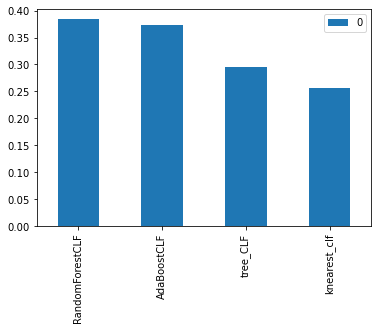

In [38]:
scored_models_1 = fit_score_models(x_train,Y_train,x_test,Y_test)
scored_models_df_1 = pd.DataFrame.from_dict(scored_models_1, orient = 'index')
scored_models_df_1.plot.bar();

In [39]:
# Checking the AUC score to see how accuarte is the model
random_forest_clf = RandomForestClassifier().fit(x_train,Y_train)
y_pred = random_forest_clf.predict(x_test)



In [40]:
y_pred_proba = random_forest_clf.predict_proba(x_test)
# Setting roc_auc as variable for a baseline model so then after some featire enginerring it would be easier to compare
roc_auc_score_model1 = roc_auc_score(Y_test, y_pred_proba, average="weighted", multi_class="ovr")

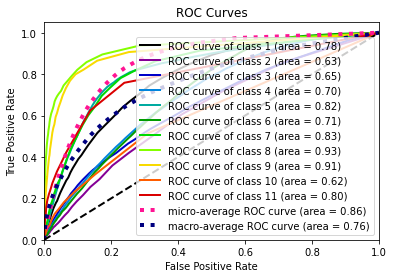

<Figure size 14400x14760 with 0 Axes>

In [41]:
import scikitplot as skplt
skplt.metrics.plot_roc(Y_test, y_pred_proba)
plt.figure(figsize=(200,205))
plt.show();


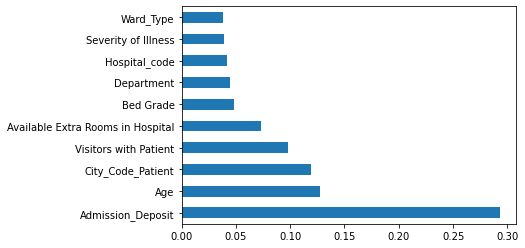

In [42]:

#plot graph of feature importances for better visualization
feat_importances = pd.Series(random_forest_clf.feature_importances_, index=x_test.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [43]:
# Getting weighted recall score for random forest classifier.
# First taking the predicated Y variable by Random forest classifer, however the resaon behind choosing micro method for avarage
#is that I want to take all the positivs and negatives into the account and then compare them with the actual outcome, I belive that gives recall value which has more meaning 
random_Forest_Recall = recall_score(Y_test, y_pred, average='micro')
print(f"The recall value for Random Forest Classifier is {random_Forest_Recall:.2f}")

The recall value for Random Forest Classifier is 0.38


## Random Forest Feature Engineering

#### First lets use one of the wrapper's method whichc would be backward elimination to see if there will be any improvment within the accuracy metric


In [44]:
# First importing stats model to get the P value which then would be our threshold when eliminating futures 

import statsmodels.api as sm

In [45]:
X_train_opt = x_train
regressor_OLS = sm.OLS(endog = Y_train, exog = X_train_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Stay   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.861
Method:                 Least Squares   F-statistic:                          1.037e+05
Date:                Sun, 09 Jan 2022   Prob (F-statistic):                        0.00
Time:                        11:23:38   Log-Likelihood:                     -5.0937e+05
No. Observations:              251033   AIC:                                  1.019e+06
Df Residuals:                  251018   BIC:                                  1.019e+06
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Hospital_code                         0.0072      0.000     16.385      0.000       0.006       0.008
Hospital_type_code                    0.0225      0.003      8.697      0.000       0.017       0.028
City_Code_Hospital                   -0.0010      0.001     -0.847      0.397      -0.003       0.001
Hospital_region_code                  0.0496      0.006      8.479      0.000       0.038       0.061
Available Extra Rooms in Hospital     0.0844      0.003     26.938      0.000       0.078       0.091
Department                            0.2033      0.006     32.856      0.000       0.191       0.215
Ward_Type                             0.3024      0.005     61.392      0.000       0.293       0.312
Ward_Facility_Code                    0.0950      0.002     38.009      0.000       0.090       0.100
Bed Grade                            -0.0335      0.004     -8.032      0.000      -0.042      -0.025
City_Code_Patient                     0.0042      0.001      5.419      0.000       0.003       0.006
Type of Admission                     0.2740      0.005     50.453      0.000       0.263       0.285
Severity of Illness                   0.0472      0.005      9.965      0.000       0.038       0.057
Visitors with Patient                 0.3297      0.002    155.575      0.000       0.326       0.334
Age                                   0.0720      0.002     38.003      0.000       0.068       0.076
Admission_Deposit                     0.0002   3.09e-06     74.139      0.000       0.000       0.000
==============================================================================
Omnibus:                     3291.536   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3652.259
Skew:                           0.246   Prob(JB):                         0.00
Kurtosis:                       3.328   Cond. No.                     8.89e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# Now lets remove the feature with the highest p value - significance level bigger than 0.05 

# In this case it would be 'City Code Hospital' column 

x_train_fs = x_train
x_train_fs = x_train_fs.drop(columns=['City_Code_Hospital'], axis = 1)


In [47]:
# Lets now re run the whole proccess again 
regressor_OLS = sm.OLS(endog = Y_train, exog = x_train_fs).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Stay   R-squared (uncentered):                   0.861
Model:                            OLS   Adj. R-squared (uncentered):              0.861
Method:                 Least Squares   F-statistic:                          1.112e+05
Date:                Sun, 09 Jan 2022   Prob (F-statistic):                        0.00
Time:                        11:23:38   Log-Likelihood:                     -5.0937e+05
No. Observations:              251033   AIC:                                  1.019e+06
Df Residuals:                  251019   BIC:                                  1.019e+06
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Hospital_code                         0.0072      0.000     16.413      0.000       0.006       0.008
Hospital_type_code                    0.0226      0.003      8.736      0.000       0.018       0.028
Hospital_region_code                  0.0495      0.006      8.467      0.000       0.038       0.061
Available Extra Rooms in Hospital     0.0842      0.003     26.951      0.000       0.078       0.090
Department                            0.2029      0.006     32.892      0.000       0.191       0.215
Ward_Type                             0.3018      0.005     62.062      0.000       0.292       0.311
Ward_Facility_Code                    0.0951      0.002     38.059      0.000       0.090       0.100
Bed Grade                            -0.0335      0.004     -8.035      0.000      -0.042      -0.025
City_Code_Patient                     0.0042      0.001      5.426      0.000       0.003       0.006
Type of Admission                     0.2739      0.005     50.446      0.000       0.263       0.285
Severity of Illness                   0.0471      0.005      9.946      0.000       0.038       0.056
Visitors with Patient                 0.3296      0.002    155.782      0.000       0.325       0.334
Age                                   0.0719      0.002     38.016      0.000       0.068       0.076
Admission_Deposit                     0.0002   3.08e-06     74.159      0.000       0.000       0.000
==============================================================================
Omnibus:                     3296.225   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3657.817
Skew:                           0.246   Prob(JB):                         0.00
Kurtosis:                       3.328   Cond. No.                     8.89e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
x_test_fs = x_test
x_test_fs = x_test_fs.drop(columns=['City_Code_Hospital'], axis = 1)
x_test_fs.head()

,Hospital_code,Hospital_type_code,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
107396,14,0,0,4,1,1,4,1.0,15.0,0,0,3,5,4252.0
49367,16,2,2,3,2,2,0,2.0,25.0,1,2,2,3,6027.0
110756,26,1,1,4,2,1,3,2.0,8.0,0,0,4,6,3056.0
9165,28,1,0,2,2,2,5,2.0,8.0,1,2,2,3,5065.0
174463,11,1,1,2,2,1,3,3.0,9.0,0,2,2,9,5024.0


In [49]:
# Lets now fit dataset with reduced features to the Random Forest Classifier 
# First lets make sure that both datasets have equal number of columns for test dataset
x_test_fs = x_test
x_test_fs = x_test_fs.drop(columns=['City_Code_Hospital'], axis = 1)
random_forest_clf = RandomForestClassifier().fit(x_train_fs,Y_train)
y_pred = random_forest_clf.predict_proba(x_test_fs)

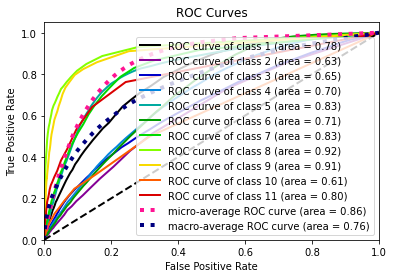

<Figure size 14400x14760 with 0 Axes>

In [50]:
skplt.metrics.plot_roc(Y_test, y_pred)
plt.figure(figsize=(200,205))
plt.show();


In [51]:
y_pred = random_forest_clf.predict(x_test_fs)
random_forest_acc = metrics.accuracy_score(Y_test, y_pred)

print(f"Random Forest Classifier Accuracy after the backward elimination is: {random_forest_acc:.2f}")

Random Forest Classifier Accuracy after the backward elimination is: 0.38


In [52]:
# Because we got worse score and that is most likely because the dataset is small and there is not much columns
#I would discard the dataset after the backward elimination and come back to the orginal one but now focus on feature engineering to try get better results

In [53]:
x_train.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
36237,23,0,6,0,4,2,1,5,3.0,2.0,1,1,7,5,5550.0
235247,15,2,5,2,4,2,1,5,2.0,21.0,1,1,3,5,4655.0
180655,6,0,6,0,7,2,1,5,4.0,1.0,2,0,4,8,3429.0
293567,26,1,2,1,4,2,1,3,3.0,3.0,1,1,2,5,4485.0
247990,4,0,4,0,2,2,2,5,3.0,1.0,1,2,2,8,5047.0


### <center>Feature Engineering

#### Checking the mean of the target for each of the columns 

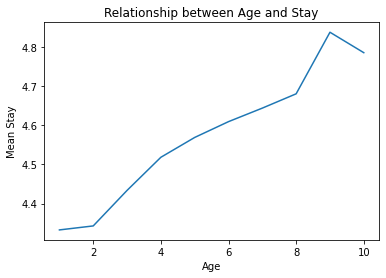

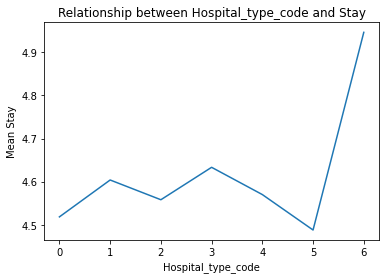

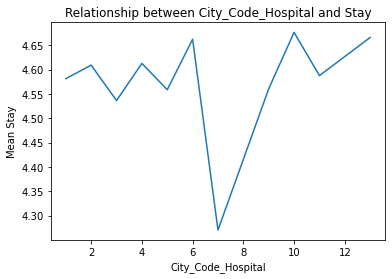

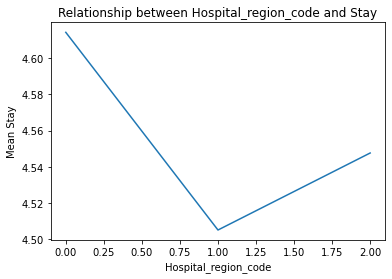

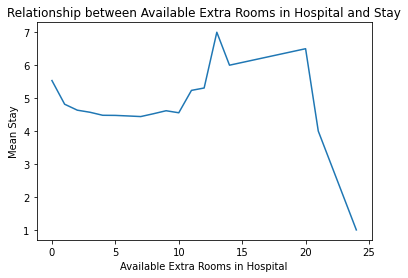

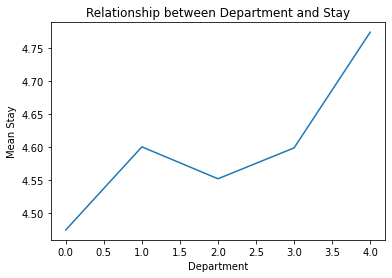

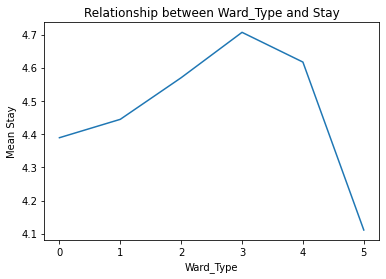

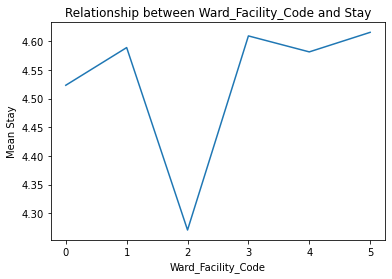

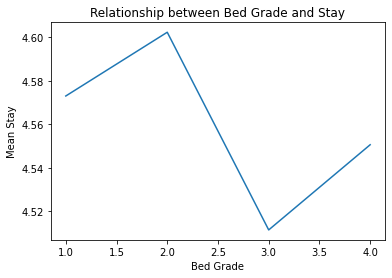

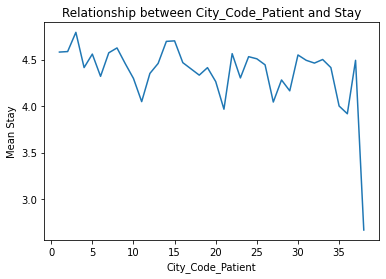

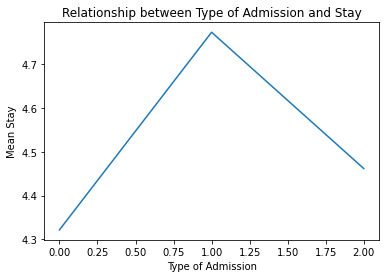

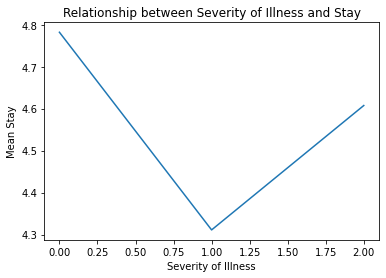

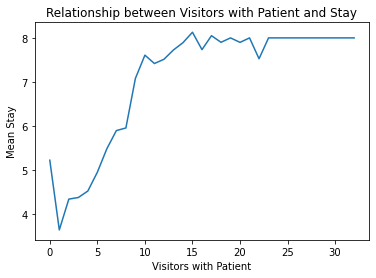

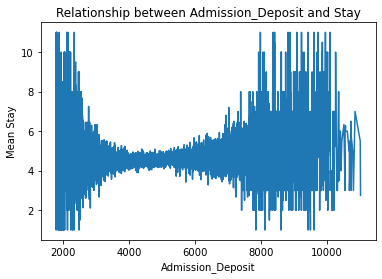

In [54]:
for var in ['Age','Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'City_Code_Patient', 'Type of Admission', 'Severity of Illness',
       'Visitors with Patient', 'Admission_Deposit']:
    fig = plt.figure()
    fig = training_df.groupby([var])['Stay'].mean().plot()
    fig.set_title('Relationship between {} and Stay'.format(var))
    fig.set_ylabel('Mean Stay')
    plt.show()

In [55]:
# Lets calculate the mean per category for Hospital Type Code and put it in the dictionary
ordered_labels_hospital_code = training_df.groupby(['Hospital_type_code'])['Stay'].mean().to_dict()
ordered_labels_hospital_code

{0: 4.518625373039108,
 1: 4.6040366972477065,
 2: 4.558311834358669,
 3: 4.633401120976142,
 4: 4.570287408383431,
 5: 4.488211343622763,
 6: 4.945952324758084}

In [56]:
# Lets create the function that find category and replace them with grouped by mean, so we do not have to write it all again but just call the function 

def find_category_maps (df,variable, target):
    """
    This function takes dataframe with variable and target:
    df: dataframe
    varaiable: the variable within the dataframe for which you are trying to find the mean of the target variable
    target: name of the target variable within you dataframe
    """
    return df.groupby([variable])[target].mean().to_dict()

def integer_encode(train_data, test_data, variable, ordinal_mapping):
    train_data[variable] = train_data[variable].map(ordinal_mapping)
    test_data[variable] = test_data[variable].map(ordinal_mapping)
    

In [57]:
mapping_Age = find_category_maps (training_df,'Age', 'Stay')
mapping_city_code = find_category_maps (training_df,'City_Code_Hospital', 'Stay')
mapping_hosp_code = find_category_maps (training_df,'Hospital_code', 'Stay')
mapping_hospital_region = find_category_maps (training_df,'Hospital_region_code', 'Stay')
mapping_extra_rooms = find_category_maps (training_df,'Available Extra Rooms in Hospital', 'Stay')
mapping_Departemnt = find_category_maps (training_df,'Department', 'Stay')
mapping_ward = find_category_maps (training_df,'Ward_Facility_Code', 'Stay')
mapping_ward_type = find_category_maps (training_df,'Ward_Type', 'Stay')
mapping_bed = find_category_maps (training_df,'Bed Grade', 'Stay')
mapping_city_patient = find_category_maps (training_df,'City_Code_Patient', 'Stay')
mapping_type_admin = find_category_maps (training_df,'Type of Admission', 'Stay')
mapping_severity = find_category_maps (training_df, 'Severity of Illness', 'Stay')
mapping_visit = find_category_maps (training_df,'Visitors with Patient', 'Stay')
mapping_admin_dep = find_category_maps (training_df,'Admission_Deposit', 'Stay')


In [58]:
training_df.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,2,3,2,3,3,2,5,2.0,7.0,0,0,2,6,4911.0,1
2,10,4,1,0,2,1,3,4,2.0,7.0,1,0,2,6,4745.0,3
3,26,1,2,1,2,3,2,3,2.0,7.0,1,0,2,6,7272.0,2
4,26,1,2,1,2,3,3,3,2.0,7.0,1,0,2,6,5558.0,2
5,23,0,6,0,2,1,3,5,2.0,7.0,1,0,2,6,4449.0,4


In [59]:
x_train.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
36237,23,0,6,0,4,2,1,5,3.0,2.0,1,1,7,5,5550.0
235247,15,2,5,2,4,2,1,5,2.0,21.0,1,1,3,5,4655.0
180655,6,0,6,0,7,2,1,5,4.0,1.0,2,0,4,8,3429.0
293567,26,1,2,1,4,2,1,3,3.0,3.0,1,1,2,5,4485.0
247990,4,0,4,0,2,2,2,5,3.0,1.0,1,2,2,8,5047.0


In [60]:
integer_encode(x_train, x_test, 'Age', mapping_Age)
integer_encode(x_train, x_test, 'Hospital_code', mapping_hosp_code)
integer_encode(x_train, x_test, 'City_Code_Hospital', mapping_city_code)
integer_encode(x_train, x_test, 'Hospital_region_code', mapping_hospital_region)
integer_encode(x_train, x_test, 'Available Extra Rooms in Hospital', mapping_extra_rooms)
integer_encode(x_train, x_test, 'Department', mapping_Departemnt)
integer_encode(x_train, x_test, 'Ward_Facility_Code', mapping_ward)
integer_encode(x_train, x_test, 'Ward_Type', mapping_ward_type)
integer_encode(x_train, x_test, 'Bed Grade', mapping_bed)
integer_encode(x_train, x_test, 'City_Code_Patient', mapping_city_patient)
integer_encode(x_train, x_test, 'Type of Admission', mapping_type_admin)
integer_encode(x_train, x_test, 'Severity of Illness', mapping_severity)
integer_encode(x_train, x_test, 'Visitors with Patient',mapping_visit)
integer_encode(x_train, x_test, 'Admission_Deposit', mapping_admin_dep)


In [61]:
# Checking for null valeus in train df
x_train.isna().sum()

Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Hospital_region_code                 0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Visitors with Patient                0
Age                                  0
Admission_Deposit                    0
dtype: int64

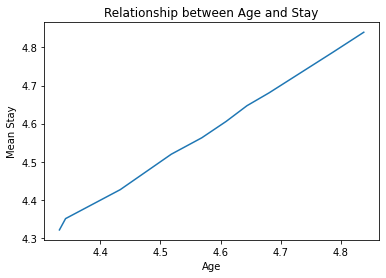

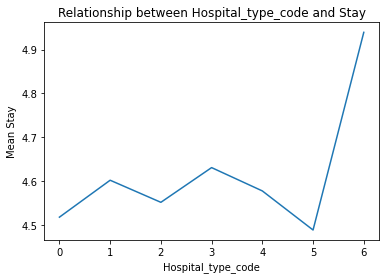

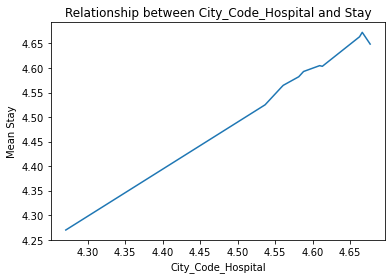

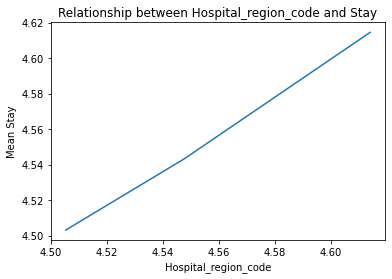

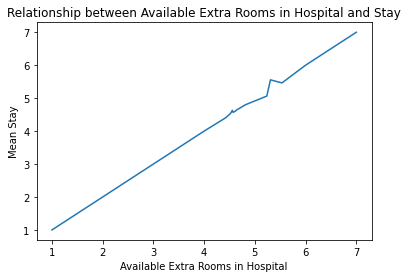

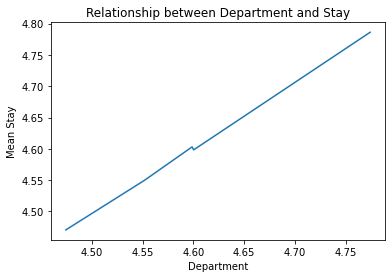

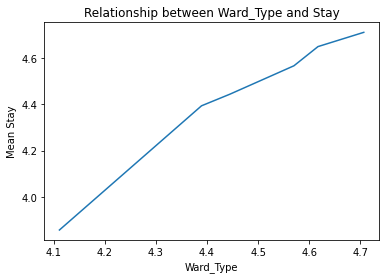

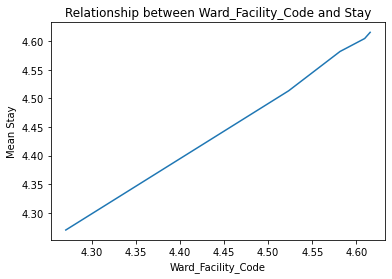

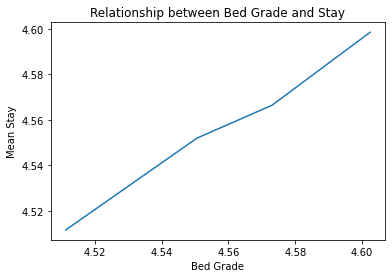

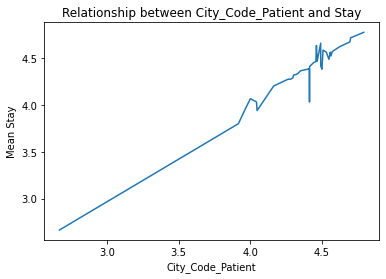

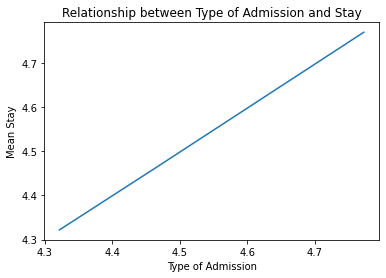

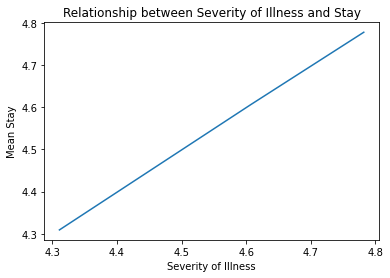

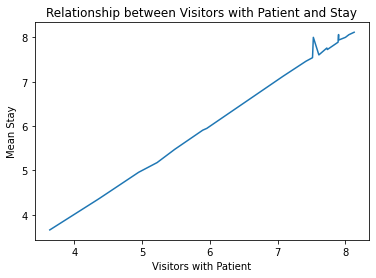

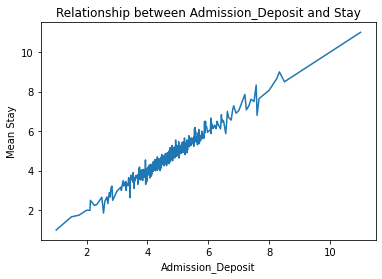

In [62]:
# Lets now check how target mean for each of the variabel is distibuted through out the dataframe 

# LEts first add the stay column into the dataframe 
stay_col = Y_train.values
stay_col_y = Y_test.values
x_train['Stay'] = stay_col
x_test['Stay'] = stay_col_y
for var in ['Age','Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'City_Code_Patient', 'Type of Admission', 'Severity of Illness',
       'Visitors with Patient', 'Admission_Deposit']:
    fig = plt.figure()
    fig = x_train.groupby([var])['Stay'].mean().plot()
    fig.set_title('Relationship between {} and Stay'.format(var))
    fig.set_ylabel('Mean Stay')
    plt.show()

### Lets now see how the model performs after feature engineering (target mean based variables)



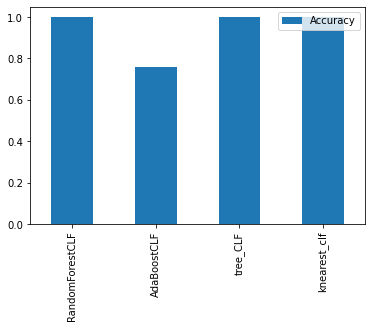

In [63]:

scored_models_2 = fit_score_models(x_train,Y_train,x_test,Y_test)
scored_models_df_2 = pd.DataFrame.from_dict(scored_models_2, orient='index')
# Renaming column name of 0 to appropiate name
scored_models_df_1.rename(columns={0:'Accuracy'}, inplace = True)
scored_models_df_2.rename(columns={0:'Accuracy'}, inplace = True)
scored_models_df_2.plot.bar();

In [64]:
random_forest_clf = RandomForestClassifier().fit(x_train,Y_train)
y_pred = random_forest_clf.predict(x_test)
roc_auc_score(Y_test, y_pred_proba, average="weighted", multi_class="ovr")

0.7238521681491024

In [65]:
y_pred = random_forest_clf.predict(x_test)
random_forest_acc_2 = metrics.accuracy_score(Y_test, y_pred)

print(f"Random Forest Classifier Accuracy after the backward elimination is: {random_forest_acc:.2f}")

Random Forest Classifier Accuracy after the backward elimination is: 0.38


In [66]:
y_pred_proba_2 = random_forest_clf.predict_proba(x_test)
roc_auc_score_model2 = roc_auc_score(Y_test, y_pred_proba_2, average="weighted", multi_class="ovr")

<AxesSubplot:>

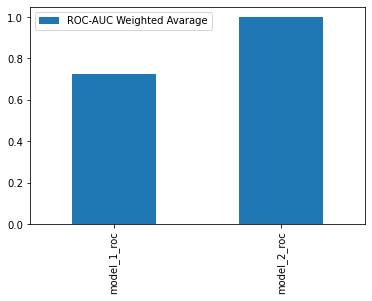

In [67]:
# Inititilizing the dictionary for roc auc score for both models 
roc_auc_dict = {"model_1_roc": [roc_auc_score_model1],
                "model_2_roc": [roc_auc_score_model2]}
# Creating dataframe from roc scores dictionary and then visualizing the diffrence

roc_scores_df = pd.DataFrame.from_dict(roc_auc_dict, orient = 'index')
# renaming column 0 with appropiate name 
roc_scores_df.rename(columns = {0: 'ROC-AUC Weighted Avarage'}, inplace = True)
roc_scores_df.plot.bar()


In [68]:
roc_scores_df

,ROC-AUC Weighted Avarage
model_1_roc,0.723852
model_2_roc,0.999999


In [69]:
scored_models_df_2

,Accuracy
RandomForestCLF,0.999602
AdaBoostCLF,0.759238
tree_CLF,1.000000
knearest_clf,0.999873


In [70]:
scored_models_df_1

,Accuracy
RandomForestCLF,0.384455
AdaBoostCLF,0.373715
tree_CLF,0.296005
knearest_clf,0.256346


In [71]:
#import pickle
# save the model to disk
#filename = 'mode2_afterFEMEAN.sav'
#pickle.dump(random_forest_clf, open(filename, 'wb'))

In [72]:
x_test.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
107396,4.720163,0,4.581495,4.614188,4.479713,4.600302,4.444586,4.581495,4.573020,4.700436,4.321709,4.782133,4.375427,4.568917,4.314961,6
49367,4.699256,2,4.536608,4.547666,4.571118,4.551841,4.569990,4.523279,4.602383,4.507519,4.772634,4.607513,4.338669,4.433502,4.545455,6
110756,4.703589,1,4.609383,4.505209,4.479713,4.551841,4.444586,4.609383,4.602383,4.624414,4.321709,4.782133,4.522359,4.609337,4.500000,1
9165,4.587892,1,4.587892,4.614188,4.634411,4.551841,4.569990,4.615612,4.602383,4.624414,4.772634,4.607513,4.338669,4.433502,4.368421,6
174463,4.424505,1,4.609383,4.505209,4.634411,4.551841,4.444586,4.609383,4.511334,4.456079,4.321709,4.607513,4.338669,4.837921,4.298013,5


In [73]:
#import nbconvert

### <center>Fixing Data Leakeage<center>

#### I have overlooked one big issue that was most likely making the second model to have almost perfect accuaracy: 
- The issue is that the test and train set both have values changed to mean of the stay - at first sight it is not the issue but wehn we look deeeper into the test set and training set it is easy to spot that the model learned to follow the mean which helps it a lot to predict the Y of test set. Due to the fact that test set features were also changed to mean of the stay the model can easy apply the knowlegde it has learned from the training set and predict Y. 
- Because the model is Random Forest Classifier which mean that the outcome is depended on what model learned throgh Yes/No questions that it has been asking while learnoing from training dataset it found the right set of answers to those quesetions which help him to predict the Y. Due to the fact that mean is Y has no much of variations for each of the features it can just answer those questions blindfolded. 
- Another big isssue is that model could never be deployed as it uses the mean of the Stay (Y) as input but in real life example that will not be possible 

The next process now that I  will do is test the model on the test set that it had not seen and transform the category features to  numerical values. I am sure that it will not perform as good as it did. 

In [74]:

training_df = pd.read_csv("train_data.csv")

training_df.loc[training_df.Stay == '0-10', 'Stay'] = 1
training_df.loc[training_df.Stay == '41-50', 'Stay'] = 2
training_df.loc[training_df.Stay == '31-40', 'Stay'] = 3
training_df.loc[training_df.Stay == '11-20', 'Stay'] = 4
training_df.loc[training_df.Stay == '51-60', 'Stay'] = 5
training_df.loc[training_df.Stay == '21-30', 'Stay'] = 6
training_df.loc[training_df.Stay == '71-80', 'Stay'] = 7
training_df.loc[training_df.Stay == 'More than 100 Days', 'Stay'] = 8
training_df.loc[training_df.Stay == '81-90', 'Stay'] = 9
training_df.loc[training_df.Stay == '61-70', 'Stay'] = 10
training_df.loc[training_df.Stay == '91-100', 'Stay'] = 11

training_df['Ward_Type'] = training_df["Ward_Type"].astype('category')
training_df['Ward_Type'] = training_df['Ward_Type'].cat.codes

training_df['Ward_Facility_Code'] = training_df["Ward_Facility_Code"].astype('category')
training_df['Ward_Facility_Code'] = training_df['Ward_Facility_Code'].cat.codes


training_df['Type of Admission'] = training_df["Type of Admission"].astype('category')
training_df['Type of Admission'] = training_df['Type of Admission'].cat.codes

# lets change the values in the Ward_type column to numeric
training_df['Severity of Illness'] = training_df["Severity of Illness"].astype('category')
training_df['Severity of Illness'] = training_df['Severity of Illness'].cat.codes

# lets change the values in the Ward_type column to numeric
training_df['Hospital_type_code'] = training_df["Hospital_type_code"].astype('category')
training_df['Hospital_type_code'] = training_df['Hospital_type_code'].cat.codes
# lets change the values in the Hospital Region code column to numeric

training_df['Hospital_region_code'] = training_df["Hospital_region_code"].astype('category')
training_df['Hospital_region_code'] = training_df['Hospital_region_code'].cat.codes

# Lets now convert it to the appropaite number
training_df.loc[training_df.Age == '0-10', 'Age'] = 1
training_df.loc[training_df.Age == '11-20', 'Age'] = 2
training_df.loc[training_df.Age == '21-30', 'Age'] = 3
training_df.loc[training_df.Age == '31-40', 'Age'] = 4
training_df.loc[training_df.Age == '41-50', 'Age'] = 5
training_df.loc[training_df.Age == '51-60', 'Age'] = 6
training_df.loc[training_df.Age == '61-70', 'Age'] = 7
training_df.loc[training_df.Age == '71-80', 'Age'] = 8
training_df.loc[training_df.Age == '81-90', 'Age'] = 9
training_df.loc[training_df.Age == '91-100', 'Age'] = 10

training_df['Age'] = training_df['Age'].astype('string').astype('int')
training_df['Stay'] = training_df['Stay'].astype('string').astype('int')

training_df['Department'] = training_df["Department"].astype('category')
training_df['Department'] = training_df['Department'].cat.codes

# Drop na values in each column
training_df.dropna(inplace=True)
training_df.drop(columns = "case_id", inplace = True)
training_df.head()


,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,2,3,2,3,3,2,5,2.0,31397,7.0,0,0,2,6,4911.0,1
1,2,2,5,2,2,3,3,5,2.0,31397,7.0,1,0,2,6,5954.0,2
2,10,4,1,0,2,1,3,4,2.0,31397,7.0,1,0,2,6,4745.0,3
3,26,1,2,1,2,3,2,3,2.0,31397,7.0,1,0,2,6,7272.0,2
4,26,1,2,1,2,3,3,3,2.0,31397,7.0,1,0,2,6,5558.0,2


In [75]:
x = training_df.drop(columns=["Stay"])
Y = training_df["Stay"]
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.20, random_state = 42, shuffle = True)

In [76]:
x_train.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
36236,15,2,5,2,4,2,1,5,1.0,79078,9.0,1,0,2,5,3597.0
235246,9,3,5,2,4,2,1,5,4.0,120404,21.0,1,1,3,5,4294.0
180654,6,0,6,0,5,2,2,5,2.0,11139,1.0,0,2,2,8,4350.0
293566,15,2,5,2,3,1,1,5,3.0,41302,5.0,2,1,6,6,5416.0
247989,28,1,11,0,2,0,2,5,3.0,95917,1.0,1,2,2,8,4713.0


In [77]:
def find_category_maps (df,variable,target):
    """
    This function takes dataframe with variable and target:
    df: dataframe
    varaiable: the variable within the dataframe for which you are trying to find the mean of the target variable
    target: name of the target variable within you dataframe
    """
    return df.groupby([variable])[target].mean().to_dict()

def integer_encode(train_data, variable, ordinal_mapping):
    train_data[variable] = train_data[variable].map(ordinal_mapping)
    #test_data[variable] = test_data[variable].map(ordinal_mapping)

In [78]:
mapping_Age = find_category_maps (training_df,'Age', 'Stay')
mapping_city_code = find_category_maps (training_df,'City_Code_Hospital', 'Stay')
mapping_hosp_code = find_category_maps (training_df,'Hospital_code', 'Stay')
mapping_hospital_region = find_category_maps (training_df,'Hospital_region_code', 'Stay')
mapping_extra_rooms = find_category_maps (training_df,'Available Extra Rooms in Hospital', 'Stay')
mapping_Departemnt = find_category_maps (training_df,'Department', 'Stay')
mapping_ward = find_category_maps (training_df,'Ward_Facility_Code', 'Stay')
mapping_ward_type = find_category_maps (training_df,'Ward_Type', 'Stay')
mapping_bed = find_category_maps (training_df,'Bed Grade', 'Stay')
mapping_city_patient = find_category_maps (training_df,'City_Code_Patient', 'Stay')
mapping_type_admin = find_category_maps (training_df,'Type of Admission', 'Stay')
mapping_severity = find_category_maps (training_df, 'Severity of Illness', 'Stay')
mapping_visit = find_category_maps (training_df,'Visitors with Patient', 'Stay')
mapping_admin_dep = find_category_maps (training_df,'Admission_Deposit', 'Stay')


integer_encode(x_train, 'Age', mapping_Age)
integer_encode(x_train, 'Hospital_code', mapping_hosp_code)
integer_encode(x_train, 'City_Code_Hospital', mapping_city_code)
integer_encode(x_train, 'Hospital_region_code', mapping_hospital_region)
integer_encode(x_train, 'Available Extra Rooms in Hospital', mapping_extra_rooms)
integer_encode(x_train, 'Department', mapping_Departemnt)
integer_encode(x_train, 'Ward_Facility_Code', mapping_ward)
integer_encode(x_train, 'Ward_Type', mapping_ward_type)
integer_encode(x_train, 'Bed Grade', mapping_bed)
integer_encode(x_train, 'City_Code_Patient', mapping_city_patient)
integer_encode(x_train, 'Type of Admission', mapping_type_admin)
integer_encode(x_train, 'Severity of Illness', mapping_severity)
integer_encode(x_train, 'Visitors with Patient',mapping_visit)
integer_encode(x_train, 'Admission_Deposit', mapping_admin_dep)


In [79]:
training_df['Department'] = training_df["Department"].astype('category')
training_df['Department'] = training_df['Department'].cat.codes

In [80]:
Y_train.head()

36236     3
235246    1
180654    3
293566    3
247989    6
Name: Stay, dtype: int32

In [81]:
Y_test.head()

107395    6
49366     4
110755    3
9164      2
174462    2
Name: Stay, dtype: int32

In [82]:
test_df.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,318439,21,c,3,Z,3,gynecology,S,A,2.0,17006,2.0,Emergency,Moderate,2,71-80,3095.0
1,318440,29,a,4,X,2,gynecology,S,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4018.0
2,318441,26,b,2,Y,3,gynecology,Q,D,4.0,17006,2.0,Emergency,Moderate,3,71-80,4492.0
3,318442,6,a,6,X,3,gynecology,Q,F,2.0,17006,2.0,Trauma,Moderate,3,71-80,4173.0
4,318443,28,b,11,X,2,gynecology,R,F,2.0,17006,2.0,Trauma,Moderate,4,71-80,4161.0


<AxesSubplot:>

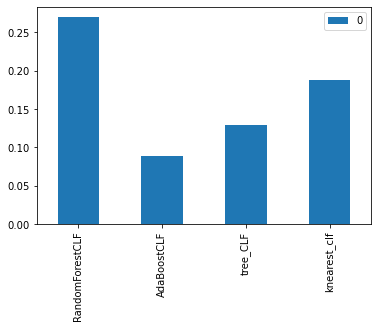

In [83]:
scored_model_3 = fit_score_models(x_train,Y_train,x_test,Y_test)
scored_model_df = pd.DataFrame.from_dict(scored_model_3, orient = 'index')
scored_model_df.plot.bar()

In [84]:
scored_model_df.head()

,0
RandomForestCLF,0.270256
AdaBoostCLF,0.088864
tree_CLF,0.129479
knearest_clf,0.187925


In [85]:
#import pickle
#with open('mode2_afterFEMEAN.sav', "rb") as f:
 #   model = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'mode2_afterFEMEAN.sav'

The solution to this problem could be creating the dataset that would contains mean alongside the features that already exist rather than swapping mean with those features. However the mean will be calcualted for the last 200 variables therefore that would leave at the beggining of the dataset 200 rows with no mean assigned for each of the features. The empty cell however will be replaced with 0s forcing the model to learn pattern and then after 200 entries it will have features mean for current feature based on the mean for the last 200 entries rather then the current one. 

- In simple explanation it will be shalolow model but learning in the way that Reccurent Neural Network learn. If that will not improve the model accuracy then I need to addd more feature engineering/do hyperparamter tuning.

In [86]:
df = training_df_copy

In [87]:
df.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,2,3,2,3,3,2,5,2.0,7.0,0,0,2,6,4911.0,1
2,10,4,1,0,2,1,3,4,2.0,7.0,1,0,2,6,4745.0,3
3,26,1,2,1,2,3,2,3,2.0,7.0,1,0,2,6,7272.0,2
4,26,1,2,1,2,3,3,3,2.0,7.0,1,0,2,6,5558.0,2
5,23,0,6,0,2,1,3,5,2.0,7.0,1,0,2,6,4449.0,4


In [88]:
x = training_df.drop(columns=["Stay"])
Y = training_df["Stay"]
#x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.20, random_state = 42, shuffle = True)

In [89]:
x.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,8,2,3,2,3,3,2,5,2.0,31397,7.0,0,0,2,6,4911.0
1,2,2,5,2,2,3,3,5,2.0,31397,7.0,1,0,2,6,5954.0
2,10,4,1,0,2,1,3,4,2.0,31397,7.0,1,0,2,6,4745.0
3,26,1,2,1,2,3,2,3,2.0,31397,7.0,1,0,2,6,7272.0
4,26,1,2,1,2,3,3,3,2.0,31397,7.0,1,0,2,6,5558.0


In [90]:
len(x)

313793

In [91]:
def find_category_maps_mean (df,variable, target):
    """
    This function takes dataframe with variable and target:
    df: dataframe
    varaiable: the variable within the dataframe for which you are trying to find the mean of the target variable
    target: name of the target variable within you dataframe
    """
    
    return df.groupby([variable])[target].mean()
# Test
x_mean = find_category_maps(df,'Hospital_code', 'Stay')

In [92]:

print(df.groupby(['Hospital_code'])['Stay'].mean())

Hospital_code
1     4.676754
2     4.847891
3     4.365292
4     4.137336
5     4.539568
6     4.635492
7     4.032309
8     4.638327
9     4.603286
10    4.520332
11    4.424505
12    4.483182
13    4.332175
14    4.720163
15    4.472301
16    4.699256
17    4.365159
18    4.666203
19    4.201711
20    4.669784
21    4.703368
22    4.945952
23    4.683402
24    4.344352
25    4.732628
26    4.703589
27    4.373520
28    4.587892
29    4.731518
30    4.483221
31    4.324771
32    4.488211
Name: Stay, dtype: float64


In [93]:
df.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,8,2,3,2,3,3,2,5,2.0,7.0,0,0,2,6,4911.0,1
2,10,4,1,0,2,1,3,4,2.0,7.0,1,0,2,6,4745.0,3
3,26,1,2,1,2,3,2,3,2.0,7.0,1,0,2,6,7272.0,2
4,26,1,2,1,2,3,3,3,2.0,7.0,1,0,2,6,5558.0,2
5,23,0,6,0,2,1,3,5,2.0,7.0,1,0,2,6,4449.0,4


In [94]:
# Setting list of v=columns names for later use in for loop to get the mean for each feature
list_of_variables = df
list_of_variables = list_of_variables.drop(columns = ['Stay'])
list_of_variables = list_of_variables.drop(columns = ['Admission_Deposit'])

In [95]:
for v in list_of_variables:
    df[f'Mean of {v}'] = find_category_maps_mean(df,v,'Stay')

In [96]:
df.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,...,Mean of Available Extra Rooms in Hospital,Mean of Department,Mean of Ward_Type,Mean of Ward_Facility_Code,Mean of Bed Grade,Mean of City_Code_Patient,Mean of Type of Admission,Mean of Severity of Illness,Mean of Visitors with Patient,Mean of Age
0,8,2,3,2,3,3,2,5,2.0,7.0,...,5.533333,4.474207,4.389170,4.523279,NaN,NaN,4.321709,4.782133,5.222222,NaN
2,10,4,1,0,2,1,3,4,2.0,7.0,...,4.634411,4.551841,4.569990,4.270686,4.602383,4.585374,4.461680,4.607513,4.338669,4.342686
3,26,1,2,1,2,3,2,3,2.0,7.0,...,4.571118,4.598714,4.706669,4.609383,4.511334,4.792153,NaN,NaN,4.375427,4.433502
4,26,1,2,1,2,3,3,3,2.0,7.0,...,4.479713,4.774278,4.617065,4.581495,4.550562,4.413356,NaN,NaN,4.522359,4.518228
5,23,0,6,0,2,1,3,5,2.0,7.0,...,4.476052,NaN,4.111111,4.615612,NaN,4.558245,NaN,NaN,4.949269,4.568917


In [97]:
df[df['Hospital_type_code']==0]['Stay']

5         4
7         2
14        1
15        1
16        1
         ..
318431    4
318433    4
318434    3
318435    4
318437    1
Name: Stay, Length: 141071, dtype: int32

In [ ]:
list_of_variables.shape

In [98]:
# test
df_unique = df['Hospital_code'].unique()
df_unique.sort()
df_unique

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int64)

In [101]:
df.loc[df['Hospital_code']==1]

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,...,Mean of Available Extra Rooms in Hospital,Mean of Department,Mean of Ward_Type,Mean of Ward_Facility_Code,Mean of Bed Grade,Mean of City_Code_Patient,Mean of Type of Admission,Mean of Severity of Illness,Mean of Visitors with Patient,Mean of Age
8,1,3,10,1,2,2,2,1,4.0,7.0,...,4.526057,NaN,NaN,NaN,NaN,4.624414,NaN,NaN,5.954346,4.680489
95,1,3,10,1,4,2,1,1,1.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,1,3,10,1,3,2,2,1,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,1,3,10,1,4,2,2,1,2.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
340,1,3,10,1,2,2,3,1,3.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318301,1,3,10,1,4,2,3,1,3.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318342,1,3,10,1,3,2,2,1,3.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318374,1,3,10,1,4,2,1,1,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318375,1,3,10,1,6,2,2,1,3.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
df = training_df
df_stay = training_df["Stay"]

In [124]:
df_stay = pd.Series(df_stay,
              name="Stay")
df_stay.to_frame()

,Stay
0,1
1,2
2,3
3,2
4,2
...,...
318433,4
318434,3
318435,4
318436,4


In [156]:
df_200 = df[:200]


In [164]:
df['Hospital_code']

0          8
1          2
2         10
3         26
4         26
          ..
318433     6
318434    24
318435     7
318436    11
318437    19
Name: Hospital_code, Length: 313793, dtype: int64

In [157]:
df_200.drop(columns=['patientid'], inplace = True)

D:\Anaconda\envs\ML\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [158]:
df_200_hospital_code = df.loc[df['Hospital_code']==1]
mean_hc = df_200_hospital_code['Stay'].mean()

In [159]:
def get_previous_mean(data_frame,slice_size,feature,list_uniques,target):
    df_ = df[:slice_size]
    df_f = df.loc[df[f'{feature}']==list_of_uniques]
    return df_f[f'{target}'].mean()

In [171]:
df_hc_uniq = df['Hospital_code'].unique()

In [174]:
df_test = get_previous_mean(df,200,'Hospital_code',df_hc_uniq,'Stay')

NameError: name 'list_of_uniques' is not defined

In [149]:
df.groupby([df['Hospital_code']==1])[df_200.loc[df['Hospital_code']]['Stay'].mean()

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_4072/4165591697.py, line 1)

In [138]:
df_200

0      1
1      2
2      3
3      2
4      2
      ..
200    6
201    3
202    6
203    5
204    7
Name: Stay, Length: 200, dtype: int32

In [111]:
list_of_variables

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age
0,8,2,3,2,3,3,2,5,2.0,7.0,0,0,2,6
2,10,4,1,0,2,1,3,4,2.0,7.0,1,0,2,6
3,26,1,2,1,2,3,2,3,2.0,7.0,1,0,2,6
4,26,1,2,1,2,3,3,3,2.0,7.0,1,0,2,6
5,23,0,6,0,2,1,3,5,2.0,7.0,1,0,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,6,0,6,0,3,3,1,5,4.0,23.0,0,2,3,5
318434,24,0,1,0,2,1,1,4,4.0,8.0,2,2,4,9
318435,7,0,4,0,3,2,2,5,4.0,10.0,0,1,3,8
318436,11,1,2,1,3,1,1,3,3.0,8.0,1,1,5,2
